## Siemens: Funtional Data Analysis Pipeline

**Index**

1. Loading the datasets
2. Preprocessing steps
   - 2.1. Data wrangling on time series
   - 2.2. Data wrangling on additional features
   - 2.3. Merging time series datasets to add additional features
       - 2.3.1. Removal of testID only exists in one sensor
3. Window extraction
   - 3.1. Validating if there are partial or full missing values after the extraction
   - 3.2. Validating shape post-window extraction
   - 3.3. Scaling the post-window data: zero-alignment
   - 3.4. Merging scaled data with additional attributes of interest
   - 3.5. Balancing the specific attributes
   - 3.6. Windows visualization (balanced data)
4. FPCA characterization
   - 4.1. Functional PC1 plots (both systems): Characterization of FPC Scores
   - 4.2 Linear Regression for slope
5. Functional Regression
   - 5.1. Regression coefficients
   - 5.2. Coefficients visualization

In [1]:
#!pip install scikit-fda
import os
os.chdir("../../")

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
import statsmodels.api as sm
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.exploratory.visualization import FPCAPlot
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot
# Import designed-functions
from window_extraction import calculate_window_values, calculate_window_data, Merge_data, align_to_zero, balance_index
from time_series_visualization import plot_all_time_series, plot_all_time_series_and_mean_fpca, plot_all_time_series_in_group
from functionalPCA import fpca_two_inputs, first_component_extraction, bootstrap, create_pc_scores_plots, visualize_regression
from functional_regression import Function_regression, coefficent_visualization

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_51522/3302358765.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 1. Loading the datasets

The path of the files can be change based on where the data is stored.

In [3]:
# Import datasets
sensorA_System1 = pd.read_csv("../../../../RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("../../../../RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("../../../../RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("../../../../RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("../../../../RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("../../../../RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("../../../../RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 2. Preprocesing Steps

## 2.1. Data wrangling on time series

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

## 2.2. Data wrangling on additional features

In [6]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})

# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.
keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])

# Binning 

# Categorize 'FluidType' into Blood and Aqueous
keyByTestID['FluidTypeBin'] = np.where(keyByTestID['FluidType'].str.startswith('Eurotrol'), 'Aqueous', 'Blood')

# Categorize 'AgeOfCardInDaysAtTimeOfTest' into bins
keyByTestID["CardAgeBin"] = pd.cut(keyByTestID["AgeOfCardInDaysAtTimeOfTest"], bins=[0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252],
                                   labels=['[0-9]', '(9-28]', '(28-56]', '(56-84]', '(84-112]', '(112-140]', '(140-168]', '(168-196]', '(196-224]', '(224-252]'])


# Categorize 'Fluid_Temperature_Filled' into bins
keyByTestID["FluidTempBin"] = pd.cut(keyByTestID["Fluid_Temperature_Filled"], bins=[-1, 20, 25, 100], labels=['Below 20', '20-25', 'Above 25'])

# Filtering successful tests
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

## 2.3. Merging time series datasets to add additional features

In [7]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3380)
A2:  (7743, 3371)
B1:  (3375, 3380)
B2:  (7745, 3371)


### 2.3.1. Removal of testID only exists in one sensor

In [8]:
# Note: Only run once. If not, restart the kernel and run from the beggining again.
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3380)
A2:  (7743, 3371)
B1:  (3374, 3380)
B2:  (7743, 3371)


# 3. Window extraction

In [9]:
# Match window values of Sensor A for each test

# Sensor A System 1
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# Sensor A System 2
calDelimit = 9.6
cal_window_size = 8
sampleDelimit = 17.2
sample_window_size = 5

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# sensor B

# For sensor B in system 1, blood and aqueous

calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous

calDelimit = 18
cal_window_size = 18
sampleDelimit_blood = 30.4
sampleDelimit_aqueous = 32.8
sample_window_size = 4

B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))


In [10]:
# Adds TestIDs as index to the values after window extraction 
# System 1 - Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B

B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID'].astype(int)
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B

B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID'].astype(int)
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)

## 3.1. Validating if there are partial or full missing values after the extraction

In [11]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

B1_cal_window_drop_index = B1_cal_window.loc[B1_cal_window.isna().sum(axis=1)!=0].index
B2_cal_window_drop_index = B2_cal_window.loc[B2_cal_window.isna().sum(axis=1)!=0].index

B1_sample_window_drop_index = B1_sample_window.loc[B1_sample_window.isna().sum(axis=1)!=0].index
B2_sample_window_drop_index = B2_sample_window.loc[B2_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_cal_window_drop_index)
print("The missing value in sample window:",B1_sample_window_drop_index)
print("The missing value in calibration window:",B2_cal_window_drop_index)
print("The missing value in sample window:",B2_sample_window_drop_index)

The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([3561566, 3561567, 3565465, 3565466], dtype='int64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')


## 3.2. Validating data shape after window extraction

In [12]:
# Set index for Merge datasets
A1_Merged.set_index("TestID", inplace=True)
A2_Merged.set_index("TestID", inplace=True)
B1_Merged.set_index("TestID", inplace=True)
B2_Merged.set_index("TestID", inplace=True)

# Find missing value
print("The problem indexes after extract the window are:",A1_Merged.index.difference(A1_cal_window.index))
print("The problem indexes after extract the window are:",A1_Merged.index.difference(A1_sample_window.index))
print("The problem indexes after extract the window are:",A2_Merged.index.difference(A2_cal_window.index))
print("The problem indexes after extract the window are:",A2_Merged.index.difference(A2_sample_window.index))

print("The problem indexes after extract the window are:",B1_Merged.index.difference(B1_cal_window.index))
print("The problem indexes after extract the window are:",B1_Merged.index.difference(B1_sample_window.index))
print("The problem indexes after extract the window are:",B2_Merged.index.difference(B2_cal_window.index))
print("The problem indexes after extract the window are:",B2_Merged.index.difference(B2_sample_window.index))

A1_Merged = A1_Merged.drop(A1_Merged.index.difference(A1_cal_window.index))
A1_Merged = A1_Merged.drop(A1_Merged.index.difference(A1_sample_window.index))
A2_Merged = A2_Merged.drop(A2_Merged.index.difference(A2_cal_window.index))
A2_Merged = A2_Merged.drop(A2_Merged.index.difference(A2_sample_window.index))

B1_Merged = B1_Merged.drop(B1_Merged.index.difference(B1_cal_window.index))
B1_Merged = B1_Merged.drop(B1_Merged.index.difference(B1_sample_window.index))
B2_Merged = B2_Merged.drop(B2_Merged.index.difference(B2_cal_window.index))
B2_Merged = B2_Merged.drop(B2_Merged.index.difference(B2_sample_window.index))

# Clear the Nan in index of sensor A
A1_cal_window = A1_cal_window[~A1_cal_window.index.isna()]
A1_sample_window = A1_sample_window[~A1_sample_window.index.isna()]
A2_cal_window = A2_cal_window[~A2_cal_window.index.isna()]
A2_sample_window = A2_sample_window[~A2_sample_window.index.isna()]

# Clear the Nan in index of sensor B
B1_cal_window = B1_cal_window[~B1_cal_window.index.isna()]
B1_sample_window = B1_sample_window[~B1_sample_window.index.isna()]
B2_cal_window = B2_cal_window[~B2_cal_window.index.isna()]
B2_sample_window = B2_sample_window[~B2_sample_window.index.isna()]


The problem indexes after extract the window are: Int64Index([12470355, 12470361, 12470365, 12537663, 12539049, 12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12470355, 12470361, 12470365, 12537663, 12539049, 12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([3518677, 3518678], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([3518677, 3518678], dtype='int64', name='TestID')


In [13]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_cal_window: ', A1_cal_window.shape)
print('A2_cal_window: ', A2_cal_window.shape)
print('B1_cal_window: ', B1_cal_window.shape)
print('B2_cal_window: ', B2_cal_window.shape)

# Sample Window
print('A1_sample_window: ', A1_sample_window.shape)
print('A2_sample_window: ', A2_sample_window.shape)
print('B1_sample_window: ', B1_sample_window.shape)
print('B2_sample_window: ', B2_sample_window.shape)

# We can delete the unmatch index but it is not necessary

Shape of the time series after extraction
A1_cal_window:  (3368, 41)
A2_cal_window:  (7743, 41)
B1_cal_window:  (3373, 91)
B2_cal_window:  (7741, 91)
A1_sample_window:  (3368, 26)
A2_sample_window:  (7743, 26)
B1_sample_window:  (3373, 21)
B2_sample_window:  (7741, 21)


## 3.3. Scaling the post-window data: zero-alignment

In [14]:
# Cal Window

A1_cal_window_zero = align_to_zero(A1_cal_window)
A2_cal_window_zero = align_to_zero(A2_cal_window)
B1_cal_window_zero = align_to_zero(B1_cal_window)
B2_cal_window_zero = align_to_zero(B2_cal_window)


# Sample Window

A1_sample_window_zero = align_to_zero(A1_sample_window)
A2_sample_window_zero = align_to_zero(A2_sample_window)
B1_sample_window_zero = align_to_zero(B1_sample_window)
B2_sample_window_zero = align_to_zero(B2_sample_window)


## 3.4. Merging scaled data with additional attributes of interest

In [15]:
# Combine data: Merge the zero-aligned time series with "FluidType", "AgeOfCardInDaysAtTimeOfTest", "Fluid_Temperature_Filled", "FluidTypeBin", "CardAgeBin", "FluidTempBin"
A1_cal_window_combine = Merge_data(A1_cal_window_zero,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window_zero,A2_Merged)

B1_cal_window_combine = Merge_data(B1_cal_window_zero,B1_Merged)
B2_cal_window_combine = Merge_data(B2_cal_window_zero,B2_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window_zero,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window_zero,A2_Merged)

B1_sample_window_combine = Merge_data(B1_sample_window_zero,B1_Merged)
B2_sample_window_combine = Merge_data(B2_sample_window_zero,B2_Merged)

## 3.5. Balancing the specific attributes

In [16]:
System1_Index, System2_Index =  balance_index(A1_cal_window_combine,A2_cal_window_combine,"FluidTempBin")

System1 Sensor A & B distribution:
 Below 20    72
20-25       72
Above 25    72
Name: FluidTempBin, dtype: int64

 System2 Sensor A & B distribution:
 Below 20    72
20-25       72
Above 25    72
Name: FluidTempBin, dtype: int64


In [17]:
# Balanced data
A1_cal_window_combine_balanced = A1_cal_window_combine.loc[System1_Index]
A1_sample_window_combine_balanced = A1_sample_window_combine.loc[System1_Index]
A2_cal_window_combine_balanced = A2_cal_window_combine.loc[System2_Index]
A2_sample_window_combine_balanced = A2_sample_window_combine.loc[System2_Index]

B1_cal_window_combine_balanced = B1_cal_window_combine.loc[System1_Index]
B1_sample_window_combine_balanced = B1_sample_window_combine.loc[System1_Index]
B2_cal_window_combine_balanced = B2_cal_window_combine.loc[System2_Index]
B2_sample_window_combine_balanced = B2_sample_window_combine.loc[System2_Index]

## 3.6. Windows visualization

### Fluid Temperature

#### System 1 and System 2: Sensor A - Cal and Sample Windows

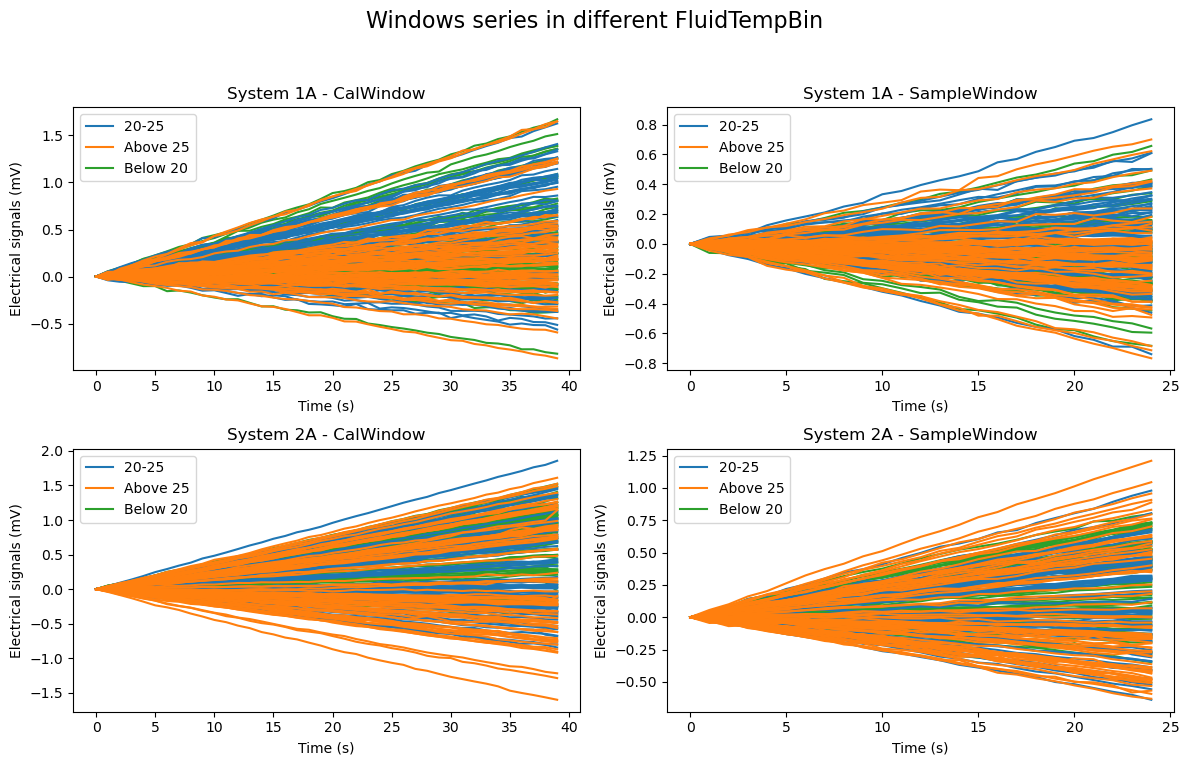

In [18]:
# Plot all the balanced time series from the window extraction
plot_all_time_series_in_group(A1_cal_window_combine_balanced, A1_sample_window_combine_balanced, A2_cal_window_combine_balanced, A2_sample_window_combine_balanced, "FluidTempBin", "System 1A - CalWindow", "System 1A - SampleWindow","System 2A - CalWindow", "System 2A - SampleWindow")

#### System 1 and System 2: Sensor B - Cal and Sample Windows

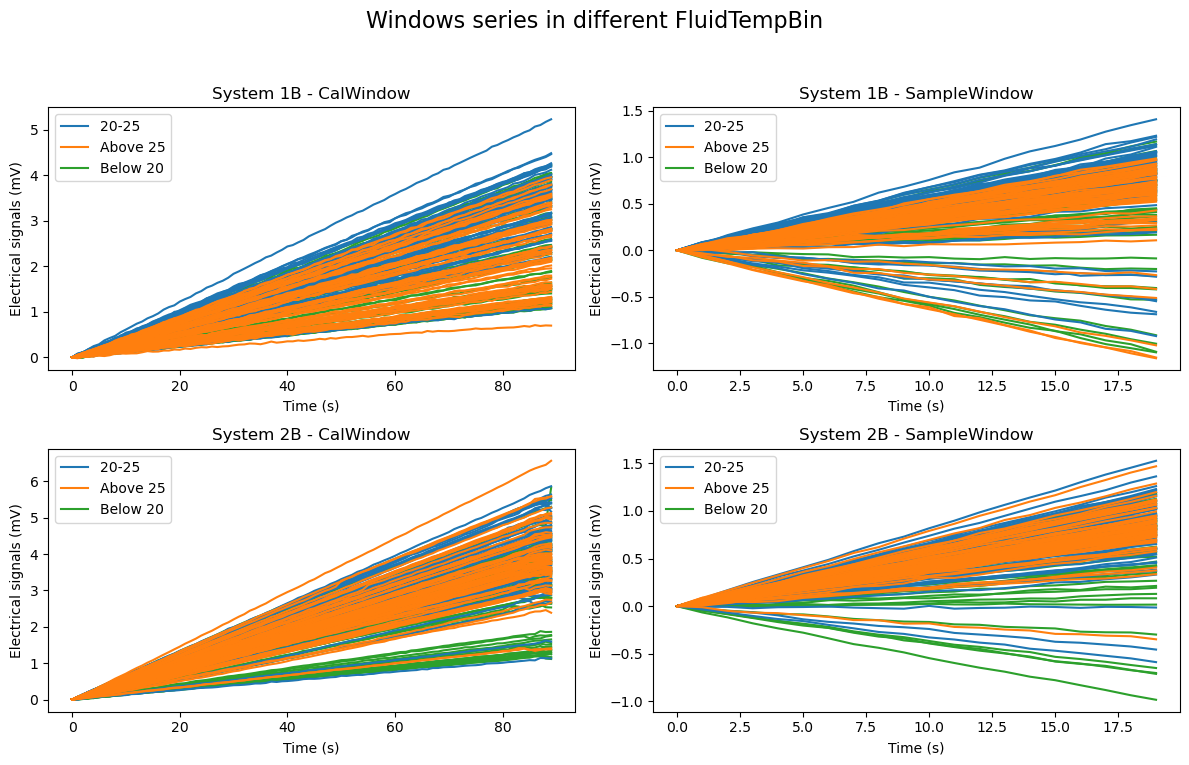

In [19]:
# Plot all the balanced time series from the window extraction
plot_all_time_series_in_group(B1_cal_window_combine_balanced, B1_sample_window_combine_balanced, B2_cal_window_combine_balanced, B2_sample_window_combine_balanced, "FluidTempBin", "System 1B - CalWindow", "System 1B - SampleWindow","System 2B - CalWindow", "System 2B - SampleWindow")


# 4. FPCA characterization

## 4.1. Functional PC1 plots (both systems) and Characterization of FPC Scores

The following seccion will introduce 
1. Percentage of variance explain by the components.
2. Time series with the major contribution on the components.
3. Plot 1-2: All the waveforms and the mean function.
4. Plot 3-4: First two components in different systems.
5. Plot 5: First component (eigenfunction) of the two systems.
6. Plot 6: The confidence interval of the mean first component computed using bootstrap.
7. Plot 7-8: The boxplots of the generated samples of the first component.
   The boxplots show the different percentile about the first component.
    - Red dashed lines indicate detected outliers.
    - Red area shows the box region.
9. Plot 9-12: Eigenvalues (scores) colored-mapping by attributes.

### System 1 versus System 2: Sensor A - Cal Window

S1 Explain variance PC1 (%):  99.87465205269854
S1 Explain variance PC2 (%):  0.03578200678942093
S2 Explain variance PC1 (%):  99.95429240592141
S2 Explain variance PC2 (%):  0.013076381384892482
The time series contributing most to PC1 is at index 38 with TestID 12191139.0
The time series contributing most to PC2 is at index 191 with TestID 12516002.0
The time series contributing most to PC1 is at index 188 with TestID 3568595
The time series contributing most to PC2 is at index 165 with TestID 3568995


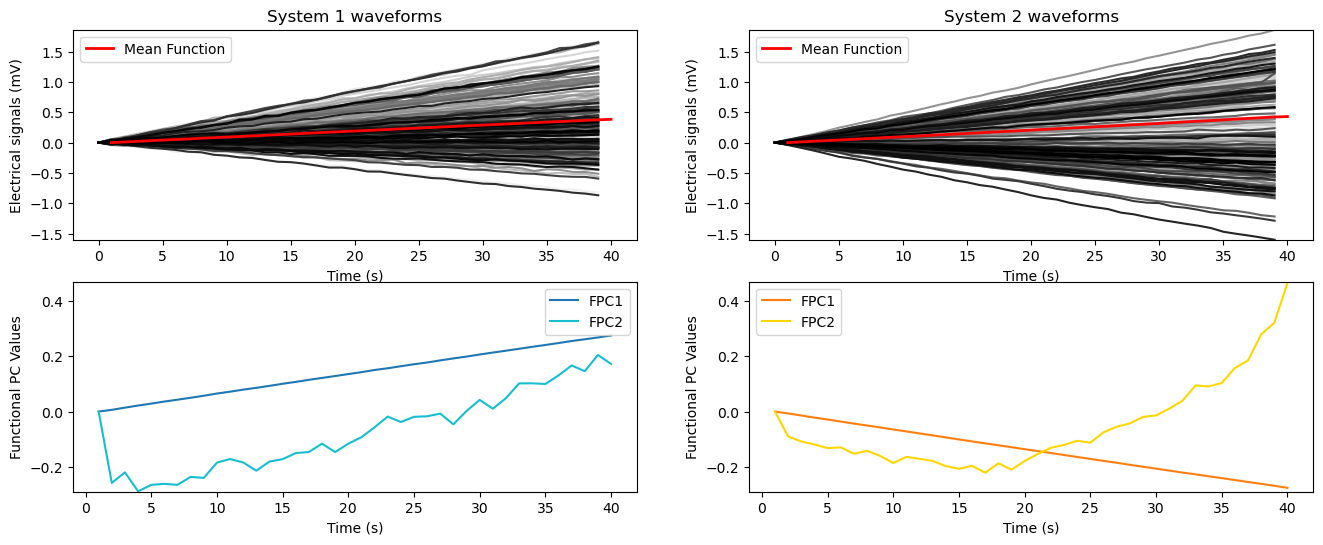

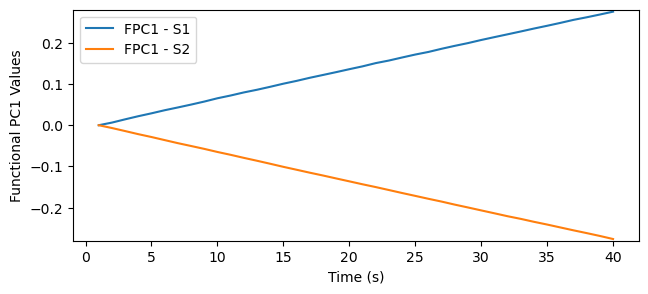

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


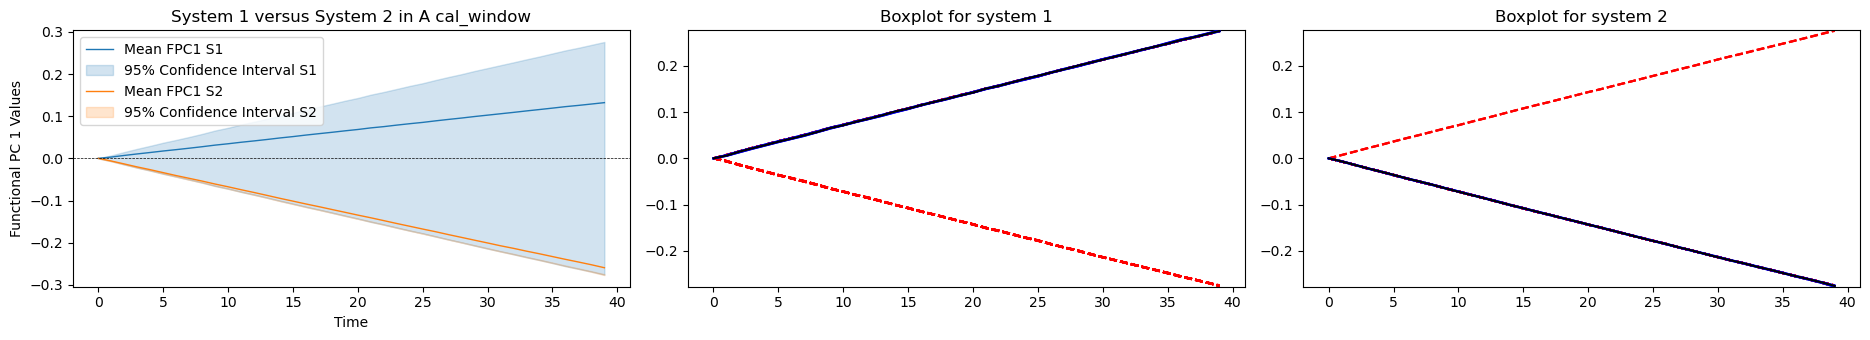

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [20]:
pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window,fpca_s1_A_cal_window,fpca_s2_A_cal_window = fpca_two_inputs(A1_cal_window_combine_balanced.iloc[:,:-6], A2_cal_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
ac1, ac2 = bootstrap(A1_cal_window_combine_balanced, A2_cal_window_combine_balanced,"A","cal_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window, A1_cal_window_combine_balanced, A2_cal_window_combine_balanced,features="FluidTempBin")

### System 1 versus System 2: Sensor A - Sample Window

S1 Explain variance PC1 (%):  99.53201594453768
S1 Explain variance PC2 (%):  0.16022779574395746
S2 Explain variance PC1 (%):  99.86999678135052
S2 Explain variance PC2 (%):  0.05127974611659295
The time series contributing most to PC1 is at index 89 with TestID 12395731.0
The time series contributing most to PC2 is at index 70 with TestID 12191109.0
The time series contributing most to PC1 is at index 187 with TestID 3569417
The time series contributing most to PC2 is at index 70 with TestID 3561425


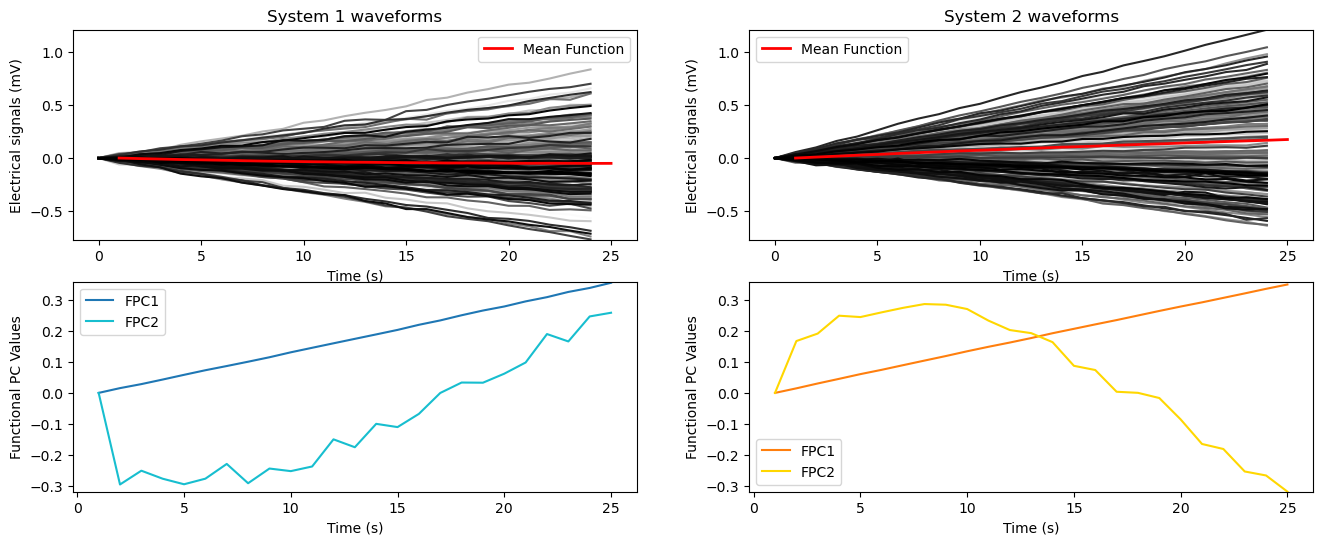

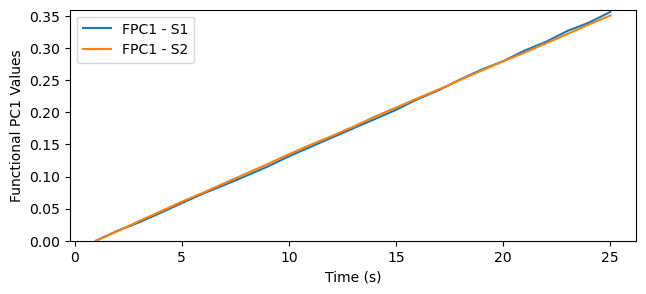

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


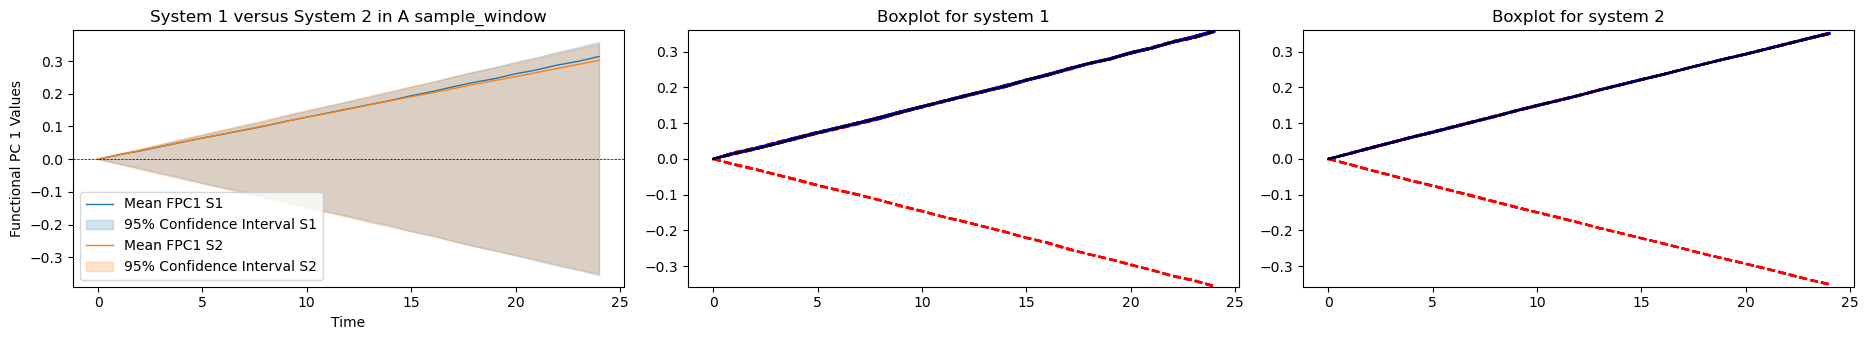

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [21]:
pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window,fpca_s1_A_sample_window,fpca_s2_A_sample_window = fpca_two_inputs(A1_sample_window_combine_balanced.iloc[:,:-6], A2_sample_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
as1,as2 = bootstrap(A1_sample_window_combine_balanced, A2_sample_window_combine_balanced,"A","sample_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window, A1_sample_window_combine_balanced, A2_sample_window_combine_balanced,features="FluidTempBin")

### System 1 versus System 2: Sensor B - Cal Window

S1 Explain variance PC1 (%):  99.92518582859792
S1 Explain variance PC2 (%):  0.0406910275514236
S2 Explain variance PC1 (%):  99.86946434373357
S2 Explain variance PC2 (%):  0.08464803794754958
The time series contributing most to PC1 is at index 89 with TestID 12395731.0
The time series contributing most to PC2 is at index 61 with TestID 12514378.0
The time series contributing most to PC1 is at index 165 with TestID 3568995.0
The time series contributing most to PC2 is at index 83 with TestID 3547583.0


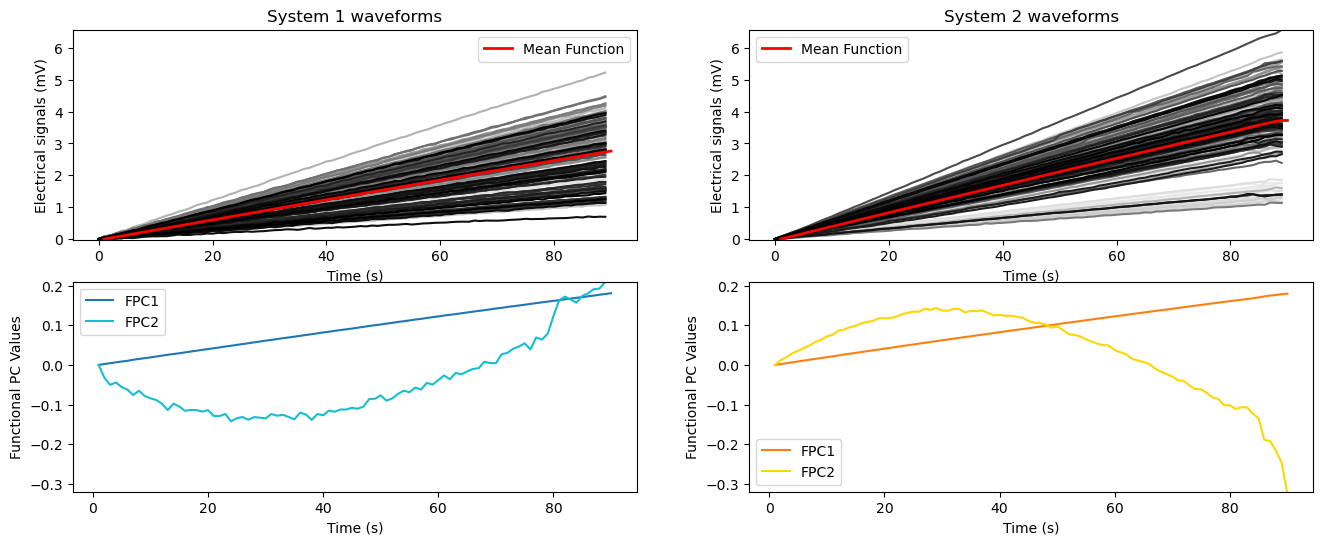

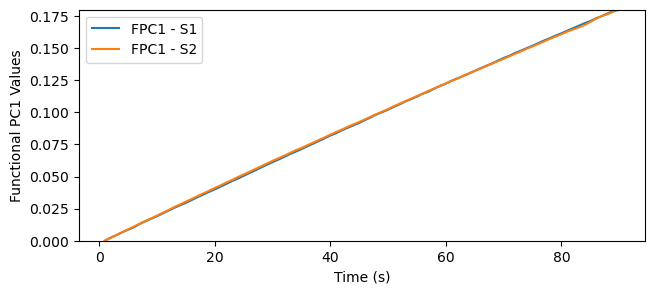

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


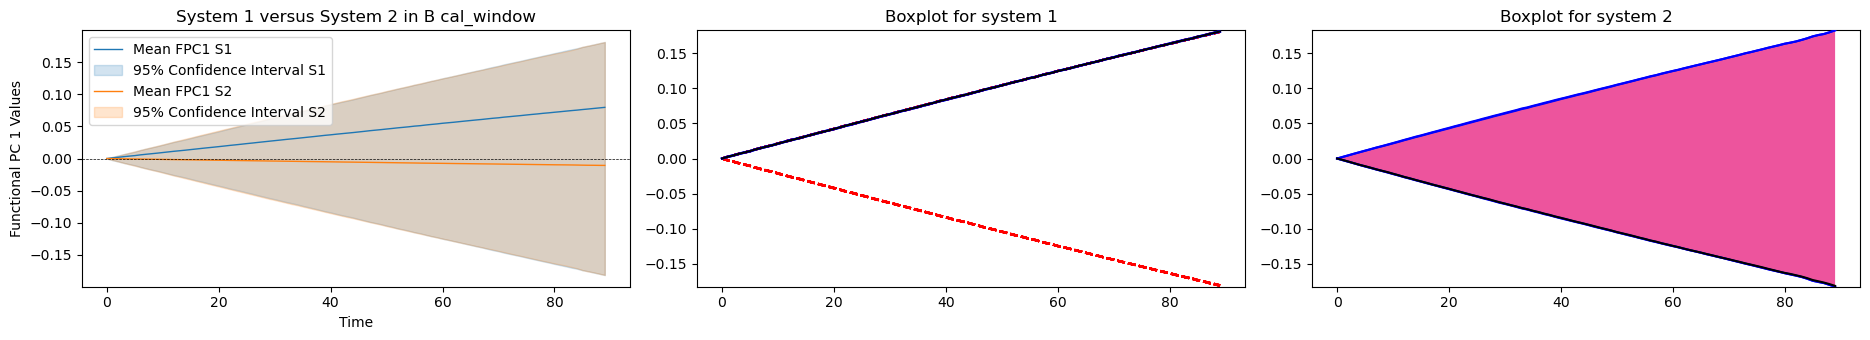

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [22]:
pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window,fpca_s1_B_cal_window,fpca_s2_B_cal_window = fpca_two_inputs(B1_cal_window_combine_balanced.iloc[:,:-6], B2_cal_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bc1,bc2 = bootstrap(B1_cal_window_combine_balanced, B2_cal_window_combine_balanced,"B","cal_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window, B1_cal_window_combine_balanced, B2_cal_window_combine_balanced,features="FluidTempBin")

### System 1 versus System 2: Sensor B - Sample Window

S1 Explain variance PC1 (%):  99.86927391203585
S1 Explain variance PC2 (%):  0.03138875441295587
S2 Explain variance PC1 (%):  99.88062943575177
S2 Explain variance PC2 (%):  0.04867213288037219
The time series contributing most to PC1 is at index 203 with TestID 12191206.0
The time series contributing most to PC2 is at index 112 with TestID 12410993.0
The time series contributing most to PC1 is at index 5 with TestID 3518443.0
The time series contributing most to PC2 is at index 205 with TestID 3560142.0


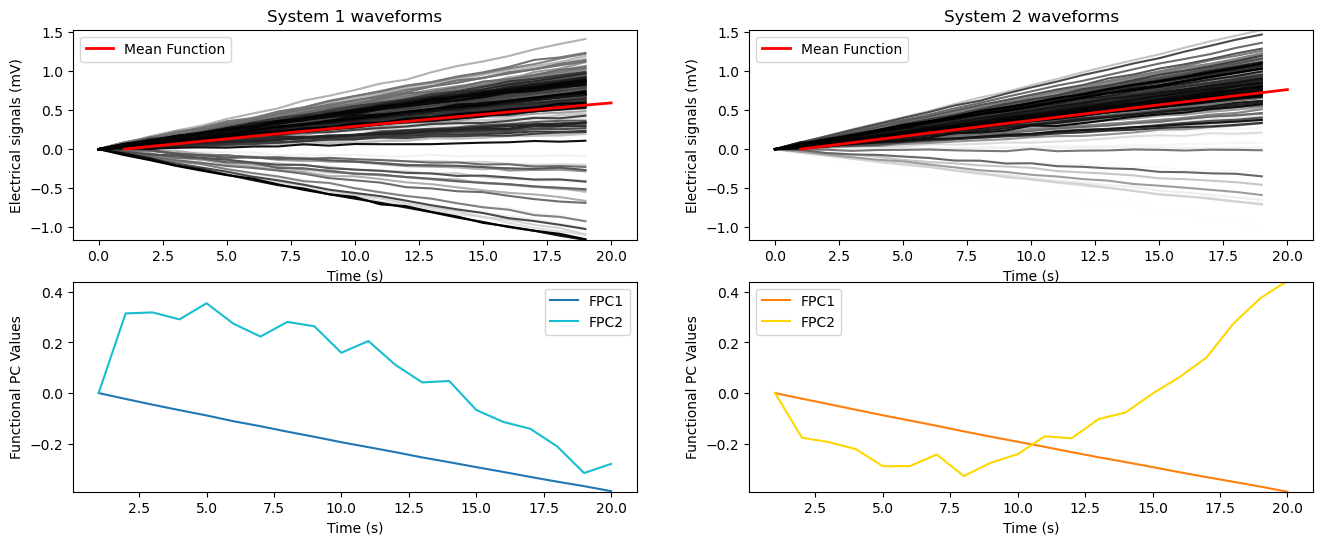

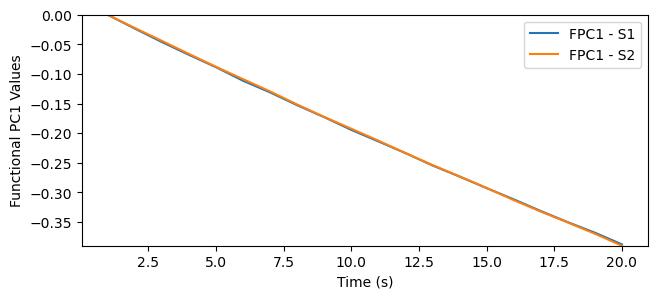

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 72
The boxplot of 1st Component


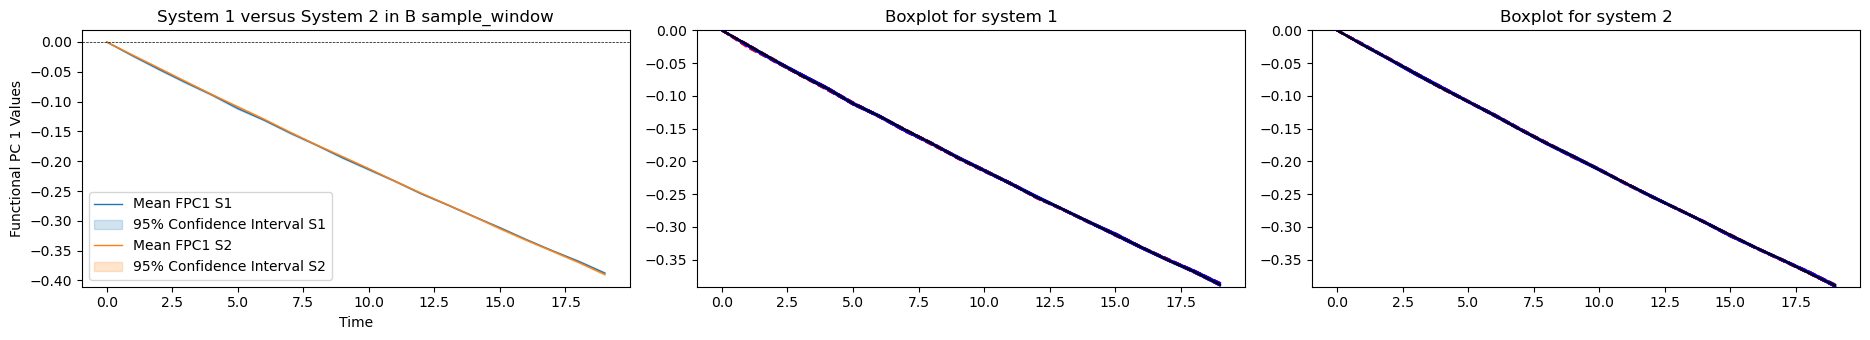

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [23]:
pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window,fpca_s1_B_sample_window,fpca_s2_B_sample_window = fpca_two_inputs(B1_sample_window_combine_balanced.iloc[:,:-6], B2_sample_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bs1,bs2 = bootstrap(B1_sample_window_combine_balanced, B2_sample_window_combine_balanced, "B","sample_window",features="FluidTempBin")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window, B1_sample_window_combine_balanced, B2_sample_window_combine_balanced,features="FluidTempBin")

## 4.2 Linear Regression for slope

### R-square and visualization

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.016e+05
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           2.08e-81
Time:                        19:37:47   Log-Likelihood:                 236.86
No. Observations:                  40   AIC:                            -469.7
Df Residuals:                      38   BIC:                            -466.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0061      0.000    -28.335      0.0

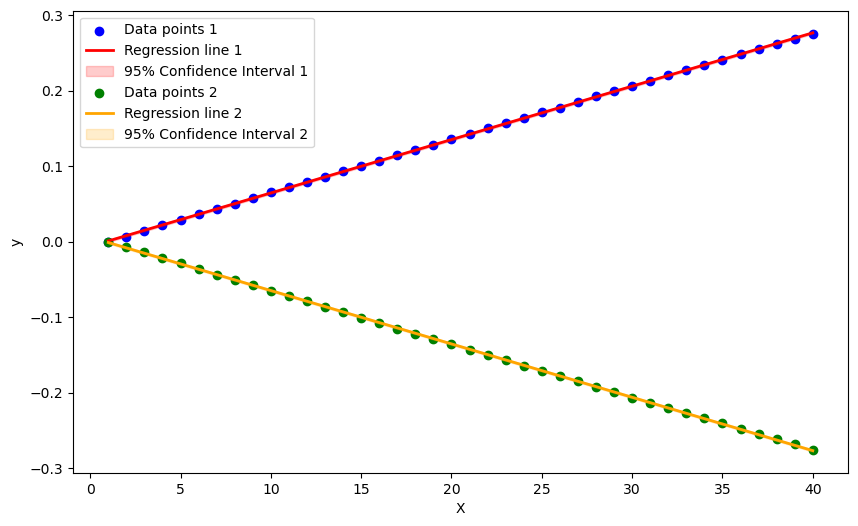

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.665e+05
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           6.74e-46
Time:                        19:37:47   Log-Likelihood:                 131.48
No. Observations:                  25   AIC:                            -259.0
Df Residuals:                      23   BIC:                            -256.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0165      0.001    -30.544      0.0

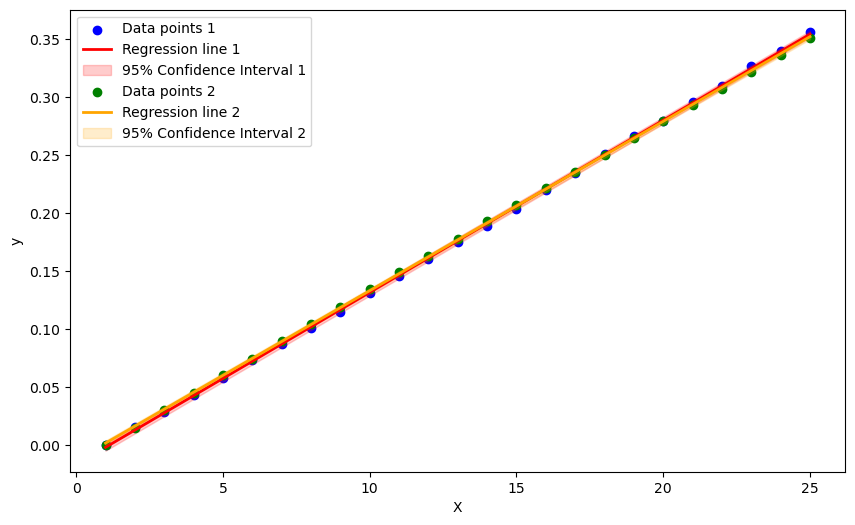

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.797e+05
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          9.71e-162
Time:                        19:37:47   Log-Likelihood:                 513.48
No. Observations:                  90   AIC:                            -1023.
Df Residuals:                      88   BIC:                            -1018.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -2.785      0.0

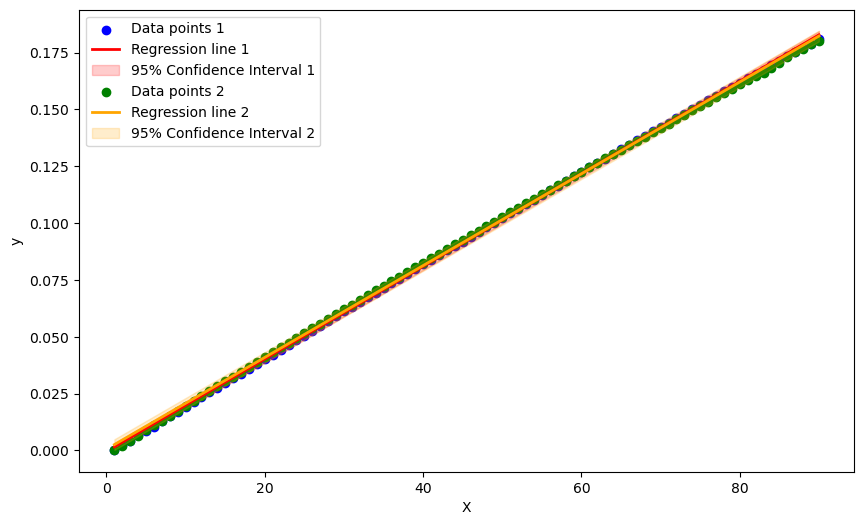

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.227e+04
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           2.71e-29
Time:                        19:37:47   Log-Likelihood:                 85.724
No. Observations:                  20   AIC:                            -167.4
Df Residuals:                      18   BIC:                            -165.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130      0.002      7.972      0.0

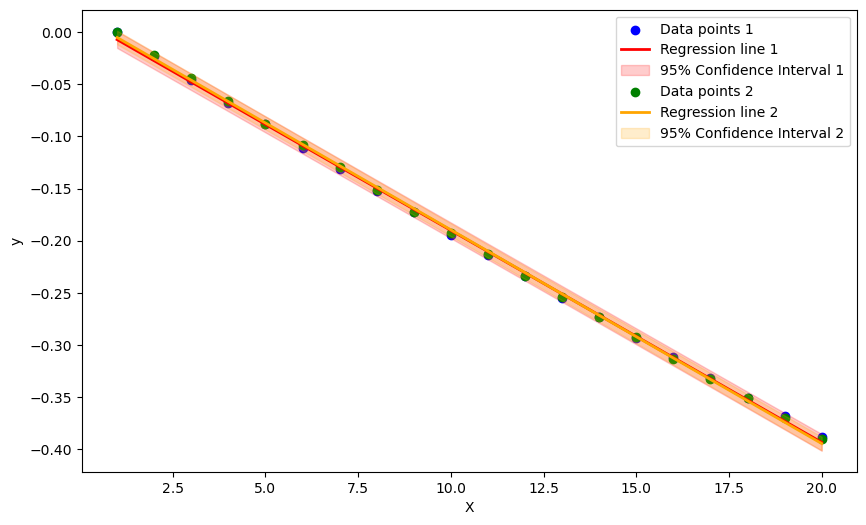

In [24]:
df_list = []

def append_to_dataframe(window_name, slope1, slope2):
    global df_list
    df_list.append({'Window': window_name, 'Slope 1': slope1, 'Slope 2': slope2})
append_to_dataframe('A_cal_window', *visualize_regression(fpca_s1_A_cal_window, fpca_s2_A_cal_window))
append_to_dataframe('A_sample_window', *visualize_regression(fpca_s1_A_sample_window, fpca_s2_A_sample_window))
append_to_dataframe('B_cal_window', *visualize_regression(fpca_s1_B_cal_window, fpca_s2_B_cal_window))
append_to_dataframe('B_sample_window', *visualize_regression(fpca_s1_B_sample_window, fpca_s2_B_sample_window))

### Slopes Results Comparison for one sample

In [25]:
slopes_df = pd.DataFrame(df_list)
slopes_df

,Window,Slope 1,Slope 2
0,A_cal_window,0.007072,-0.007070
1,A_sample_window,0.014846,0.014602
2,B_cal_window,0.002036,0.002018
3,B_sample_window,-0.020308,-0.020473


# 5. Functional Regression

This is another functional Data Analysis method. Unlike FPCA, the following analysis utilizes **the entire time series** in a balanced and centered dataset as response variables for regression with **the features grouped by bins**. This is done to distinguish between two systems under the influence of features.

## 5.1. Regression coefficients

These are the coefficients from the output of the model.
- Note: In the visualizations, due to the different magnitude, we need to choose the time stamps before we visualize.

### Sensor A

#### Cal window

In [26]:
print("System 1:")
A1_cal_window_funct_reg = Function_regression(A1_cal_window_combine_balanced,40,['Fluid_Temperature_Filled'])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_cal_window_funct_reg = Function_regression(A2_cal_window_combine_balanced,40,['Fluid_Temperature_Filled'])

System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 39.0),), n_basis=41, period=39.0),
    coefficients=[[ 2.30396221e+00 -9.86007375e-01 -1.34014758e-01 -6.06223882e-01
      -7.37808981e-03 -2.69622134e-01 -6.83745488e-02 -1.62632927e-01
       2.19465215e-01 -4.87588698e-02  2.60017772e-02 -1.84244644e-01
       1.23229168e-01  6.52980243e-02  9.62646007e-02 -9.16553009e-02
      -6.59010341e-02 -1.78713577e-03 -8.31831341e-02 -2.45522495e-01
       1.35203777e-01 -3.77358680e-01 -1.33556271e-01 -5.63289152e-01
       3.60634419e-02 -2.17243943e-01 -1.73457916e-01 -1.67759309e-01
       1.34983262e-02 -2.20401167e-01  7.50146485e-02 -3.86058097e-01
       1.88867392e-01 -3.48870161e-01 -2.38669606e-01 -6.68423794e-01
       3.99137263e-02 -1.08253427e+14  1.28006091e+12 -1.08253427e+14
      -1.28006091e+12]]) 

Coefficient of Fluid_Temperature_Filled: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 39.0),), n_basis=41, period=39.0),

#### Sample window

In [27]:
print("System 1:")
A1_sample_window_funct_reg = Function_regression(A1_sample_window_combine_balanced,25,["Fluid_Temperature_Filled"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_sample_window_funct_reg = Function_regression(A2_sample_window_combine_balanced,25,["Fluid_Temperature_Filled"])


System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 24.0),), n_basis=25, period=24.0),
    coefficients=[[ 6.69286203e-02 -1.12414675e-01  1.10135558e-01  1.45408163e-01
      -1.36013158e-01 -3.69605803e-02  1.07482873e-01  9.51238816e-02
       1.58242603e-01  4.35823740e-02  1.19307512e-01  4.49089397e-02
      -6.51841479e-04 -1.09400998e-02  7.30206072e-03 -6.08749647e-02
       1.06635615e-01 -7.59142598e-02  3.10362432e-02 -9.50326621e-02
      -2.09933223e-01  1.87536271e-01  2.60293002e-02 -4.45372723e+13
      -1.15704374e-01]]) 

Coefficient of Fluid_Temperature_Filled: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 24.0),), n_basis=25, period=24.0),
    coefficients=[[-9.86918625e-03  6.30885540e-03 -2.44893104e-03 -5.90362482e-03
       6.24712174e-03  4.80599385e-04 -5.06537823e-03 -3.79966532e-03
      -8.07586514e-03 -3.07249983e-03 -9.36670656e-03  3.64846470e-03
      -1.21359328e-03  1.20755219e-03  8.78175112e-04  5

### Sensor B

#### Cal window

In [28]:
print("System 1:")
B1_cal_window_funct_reg = Function_regression(B1_cal_window_combine_balanced,90,["Fluid_Temperature_Filled"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_cal_window_funct_reg = Function_regression(B2_cal_window_combine_balanced,90,["Fluid_Temperature_Filled"])

System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 89.0),), n_basis=91, period=89.0),
    coefficients=[[ 1.33346922e+01 -5.56504179e+00 -9.78408940e-01 -1.78462998e+00
      -1.47085412e-01 -2.31306306e+00  3.12567926e-01 -2.03973628e+00
      -2.75984149e-01 -3.60054434e-02 -5.80738893e-01 -1.47042911e-01
       6.39849774e-01 -7.01533285e-01  6.35140519e-01  4.82783154e-01
      -7.49924296e-02 -3.76458817e-01 -2.67923594e-01 -1.01688789e+00
       7.31101447e-01 -1.68771045e+00  3.88593966e-01 -1.82256090e+00
      -4.12751516e-01 -2.16087733e+00  1.08906778e-01 -2.22618116e+00
      -8.95034454e-01 -1.28452791e+00 -9.03127202e-01  7.72428871e-01
      -5.65235575e-01 -7.25353068e-01 -6.65451301e-02 -1.36947361e+00
      -1.08099003e+00  1.19538644e-01 -1.04844597e+00 -4.96130432e-01
      -9.24047956e-01 -5.84926873e-01  2.38595712e-01 -2.53037946e-01
      -1.26949751e+00 -5.37268514e-01 -1.65954465e+00 -2.99083083e-01
      -6.36341566e

#### Sample window

In [29]:
print("System 1:")
B1_sample_window_funct_reg = Function_regression(B1_sample_window_combine_balanced,20,["Fluid_Temperature_Filled"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_sample_window_funct_reg = Function_regression(B2_sample_window_combine_balanced,20,["Fluid_Temperature_Filled"])

System 1:
Model Summary: 

Intercept: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 19.0),), n_basis=21, period=19.0),
    coefficients=[[ 1.39322909e+00 -5.06291480e-01  2.91510356e-01 -3.70159238e-01
      -7.66127309e-01  2.57225305e-01  2.57729781e-01  3.15773235e-01
       9.30479125e-01 -6.39203796e-01  4.93296725e-01 -3.98865852e-01
       5.07389524e-01  7.41602575e-01  3.88979800e-01 -9.05845552e-02
       7.71994745e-01 -3.45480962e+14  1.70607882e+12 -3.45480962e+14
      -1.70607882e+12]]) 

Coefficient of Fluid_Temperature_Filled: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 19.0),), n_basis=21, period=19.0),
    coefficients=[[ 8.17161247e-03 -3.31781447e-03  3.85626063e-03  2.64564166e-03
       4.76277862e-02 -2.31803908e-02  3.39760498e-03 -2.09573315e-02
      -2.64454120e-02  1.61228466e-02 -7.78336298e-03  5.49122160e-03
      -6.77625616e-03 -4.06072618e-02 -2.80300832e-03 -1.39947045e-02
      -2.04386252e-02 -2.12409930e+12  1.04893792e+10 -2

## 5.2. Coefficients visualization

### Sensor A

#### Cal window

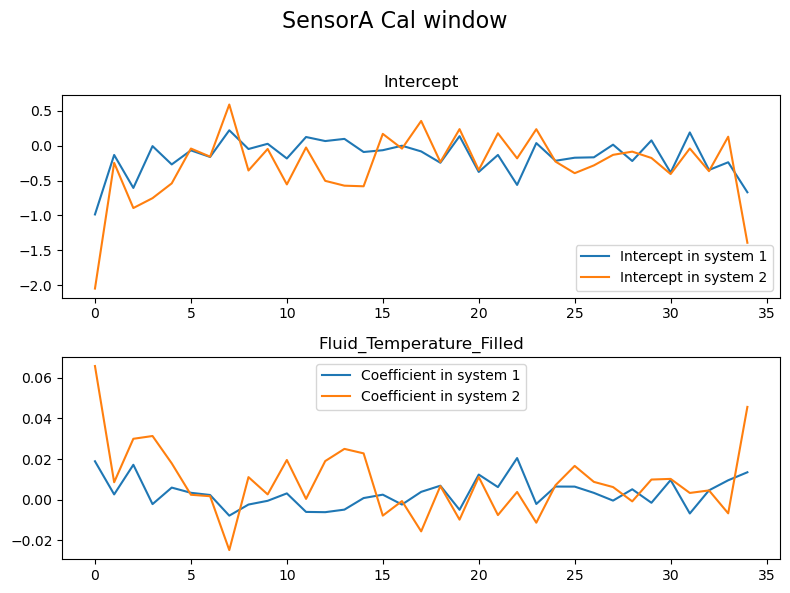

In [30]:
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["Fluid_Temperature_Filled"],range(1,36),"SensorA Cal window")

#### Sample window

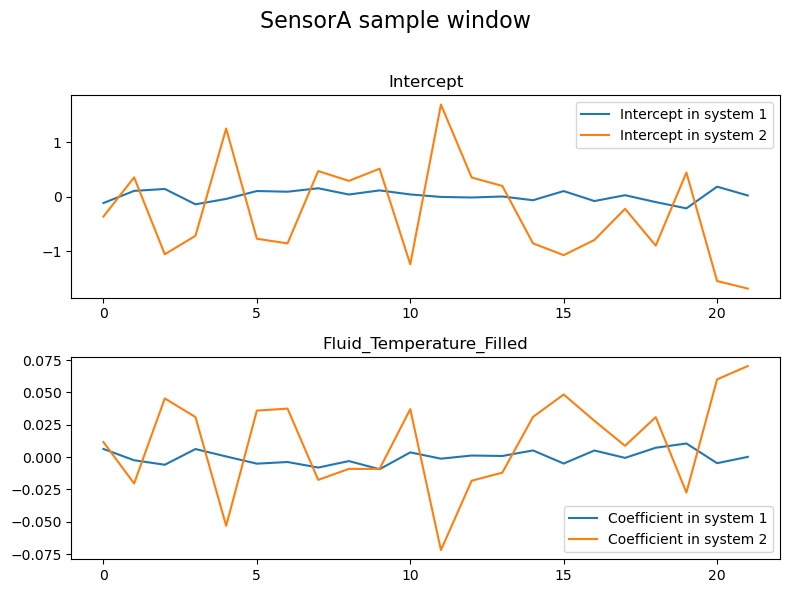

In [31]:
coefficent_visualization(A1_sample_window_funct_reg,A2_sample_window_funct_reg,["Fluid_Temperature_Filled"],range(1,23),"SensorA sample window")

### Sensor B

#### Cal window

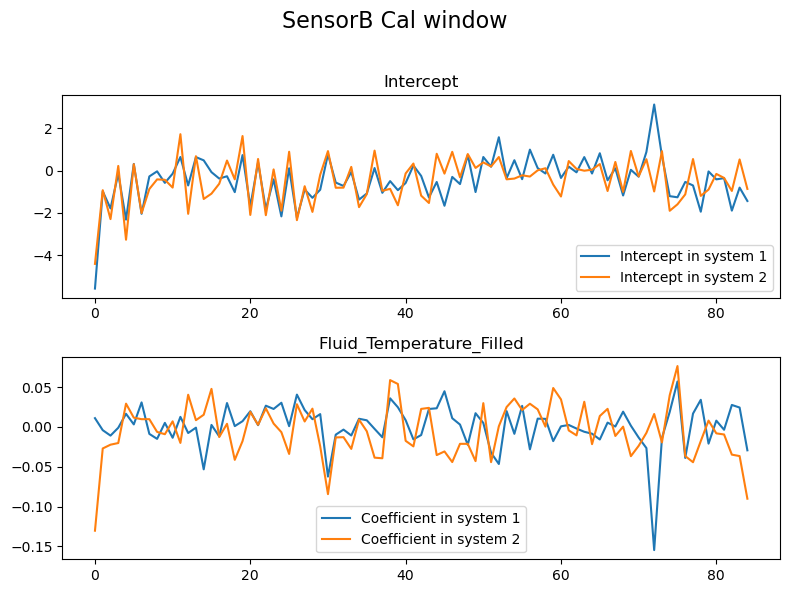

In [32]:
coefficent_visualization(B1_cal_window_funct_reg,B2_cal_window_funct_reg,["Fluid_Temperature_Filled"],range(1,86),"SensorB Cal window")

#### Sample window

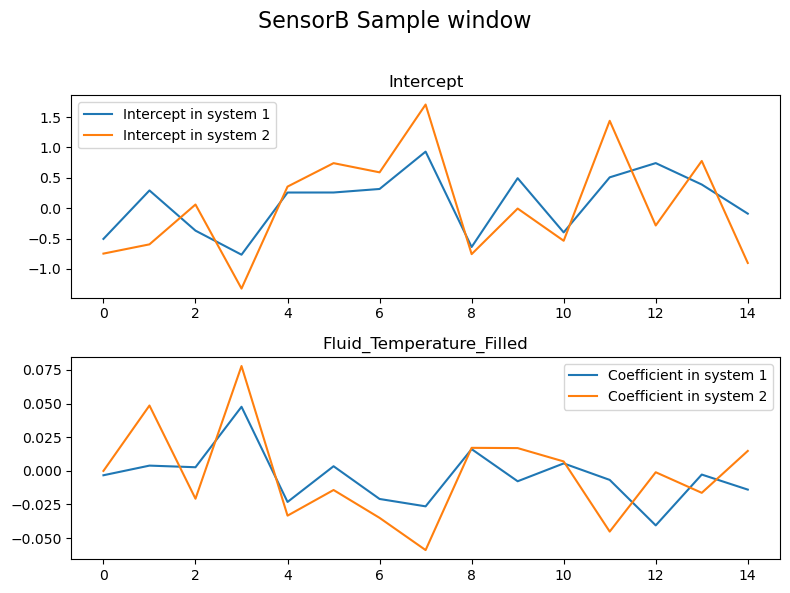

In [33]:
coefficent_visualization(B1_sample_window_funct_reg, B2_sample_window_funct_reg, ["Fluid_Temperature_Filled"], range(1, 16), "SensorB Sample window")